In [63]:
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

import numpy as np
np.set_printoptions(linewidth=np.inf, precision=2)

$$
\hat{H} = -J \left[\sum_{i} \sum_{p \in \{ x,y\}} e^{i\Phi} \ket{p_{i,\alpha}} \bra{p_{i,\beta}} + \ket{p_{i,\alpha}} \bra{p_{i,\gamma}} + \ket{p_{i,\alpha+1}} \bra{p_{i,\beta}} + \ket{p_{i,\alpha+1}} \bra{p_{i,\gamma}} + e^{-i\Phi}\ket{p_{i,\alpha}} \bra{p_{i-1,\beta}} + \ket{p_{i,\alpha}} \bra{p_{i-1,\gamma}} + h.c.\right] \\ + U \left[\sum_{j} \sum_{l \in \{\alpha,\beta,\gamma\}} \ket{x_{j,l}, y_{j,l}} \bra{x_{j,l}, y_{j,l}}\right]
$$


Let us instead consider the basis $\ket{i,l; j,m}$, where $i,j$ denote which unit cell and $l,m$ denote which of the sites in a cell

Reducing this Hamiltonian to the two particle manifold
$$
\hat{H} = \hat{H_x} + \hat{H_y} + U \sum_{i,l} \hat{n}_{x,i,l} \hat{n}_{y,i,l}
$$

Where $H_x = H_0 \otimes \mathbb{I}$. For the states where the two particles do not interact the energies are given by:

$$
E_{l,m} (K,q) = \varepsilon_l \left(\frac{K}{2} +q\right) + \varepsilon_m \left(\frac{K}{2} -q\right)
$$

where $K = k_x + k_y$ is total momentum and $q = \frac{k_x - k_y}{2}$ is relative momentum. $\varepsilon_l$ are solutions to the single particle $H_0(k) \ket{u_l} = \varepsilon_l(k) \ket{u_l}$ where $\ket{u_l}$ is the eigenvector associated with a particlar site in a unit cell in the single-particle regime. 

$$
u_l(k) = \begin{pmatrix} u_l(k;\alpha) \\ u_l(k;\beta) \\ u_l(k;\gamma)
\end{pmatrix}
$$

The bound state energies for a given K are given by finding the roots of:

$$
F_l (E) = 1 - U \sum_{m,n \in \{ \alpha,\beta,\gamma \}} \int_{-\pi}^{\pi} \frac{\mathrm{d} q}{2 \pi} \frac{|u_m\left(\frac{K}{2} + q; l \right)|^2 |u_n\left(\frac{K}{2} - q; l \right)|^2}{E - E_{m,n}(K,q)}
$$

In [112]:
#the Hamiltonian for a single particle
def add_conj(mat):
    return mat + mat.conj().T
### Binary Hamiltonian
H_0 = lambda phi,k: np.array([[0,np.exp(1j*(phi)) + np.exp(1j*(k)),1+ np.exp(1j*(k))],
                [np.exp(-1j*phi)+ np.exp(-1j*(k)),0,0],
                [1+ np.exp(-1j*(k)),0,0]])

### Ternary Hamiltonian

H_0 = lambda phi,k: add_conj(np.array([[0, np.exp(1j*phi/2) +np.exp(-1j*(k+phi/2)), 1 + np.exp(-1j*k), np.exp(-1j*phi/2) +np.exp(-1j*(k-phi/2))],[0,0,0,0],[0,0,0,0],[0,0,0,0]] ))

H_0(np.pi,np.pi/3)

array([[ 0.  +0.j  , -0.87+0.5j ,  1.5 -0.87j,  0.87-0.5j ],
       [-0.87-0.5j ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
       [ 1.5 +0.87j,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.87+0.5j ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ]])

In [113]:
H_0(0,0)

array([[0.+0.j, 2.+0.j, 2.+0.j, 2.+0.j],
       [2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [114]:
def continuum_states(h0, K, q, phi):
    eig1, _ = np.linalg.eigh(h0(phi, K/2 + q))
    eig2, _ = np.linalg.eigh(h0(phi, K/2 - q))
    # Sum all pairwise combinations
    return np.array([e1 + e2 for e1 in eig1 for e2 in eig2])

def continuum_eigs(h0, K, q, phi):
    eig1, vecs1 = np.linalg.eigh(h0(phi, K/2 + q))
    eig2, vecs2 = np.linalg.eigh(h0(phi, K/2 - q))
    # Sum all pairwise combinations
    return eig1, vecs1, eig2, vecs2

def bound_states(h0, K, phi, U,
                 n_q=400,       # # of q-points in [-π,π) for the integral
                 n_E=800,       # # of E-points to scan for sign-changes
                 E_pad=2.0      # padding beyond continuum for root search
                ):
    # 1) set up the q–grid and measure
    qs = np.linspace(-np.pi, np.pi, n_q, endpoint=False)
    dql = qs[1] - qs[0]

    # 2) precompute single‐particle eigensystems at K/2 ± q
    eig_p, vec_p = [], []
    eig_m, vec_m = [], []
    for q in qs:
        e1, u1 = np.linalg.eigh(h0(phi, K/2 + q))
        e2, u2 = np.linalg.eigh(h0(phi, K/2 - q))
        eig_p.append(e1); vec_p.append(u1)
        eig_m.append(e2); vec_m.append(u2)

    # 3) find the continuum band edges
    all_cont = np.hstack([
        eig_p[i][:,None] + eig_m[i][None,:]
        for i in range(n_q)
    ])
    E_min, E_max = all_cont.min(), all_cont.max()

    # 4) build a coarse E-grid that extends a bit beyond the continuum
    E_low, E_high = E_min - abs(U)*E_pad, E_max + abs(U)*E_pad
    E_grid = np.linspace(E_low, E_high, n_E)

    # 5) define the secular function F_l(E)
    def F(E, l):
        integral = 0.0
        for i in range(n_q):
            e1, u1 = eig_p[i], vec_p[i]
            e2, u2 = eig_m[i], vec_m[i]
            # outer product of probabilities on sublattice l
            amp = np.abs(u1[:, l])**2[:, None] * np.abs(u2[:, l])**2[None, :]
            denom = E - (e1[:, None] + e2[None, :])
            integral += np.sum(amp/denom) * dql
        # divide by 2π
        return 1.0 - U*(integral/(2*np.pi))

    # 6) scan for sign‐changes in F(E) to bracket roots, then refine
    roots = {l: [] for l in range(3)}
    for l in range(3):
        F_vals = np.array([F(E, l) for E in E_grid])
        for j in range(len(E_grid)-1):
            if np.isnan(F_vals[j]) or np.isnan(F_vals[j+1]):
                continue
            if F_vals[j]*F_vals[j+1] < 0:
                sol = root_scalar(lambda E: F(E, l),
                                  bracket=[E_grid[j], E_grid[j+1]],
                                  method='bisect',
                                  xtol=1e-6)
                if sol.converged:
                    roots[l].append(sol.root)

    return roots


<>:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
/var/folders/n7/sdrzr_l16mqf79r9kr85jqd80000gn/T/ipykernel_95527/3571823353.py:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  amp = np.abs(u1[:, l])**2[:, None] * np.abs(u2[:, l])**2[None, :]
/var/folders/n7/sdrzr_l16mqf79r9kr85jqd80000gn/T/ipykernel_95527/3571823353.py:49: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  amp = np.abs(u1[:, l])**2[:, None] * np.abs(u2[:, l])**2[None, :]


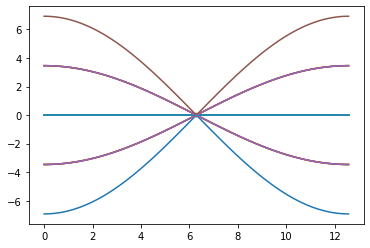

In [116]:
#K = np.pi/2
Ks=  np.linspace(0,4*np.pi,100)

#qs = np.linspace(0,2*np.pi,10)
q=0
phi = 0

bands = []
for K in Ks:
    bands.append(np.sort(continuum_states(H_0, K, q, phi)))

for band in np.array(bands).T:
    plt.plot(Ks,band)


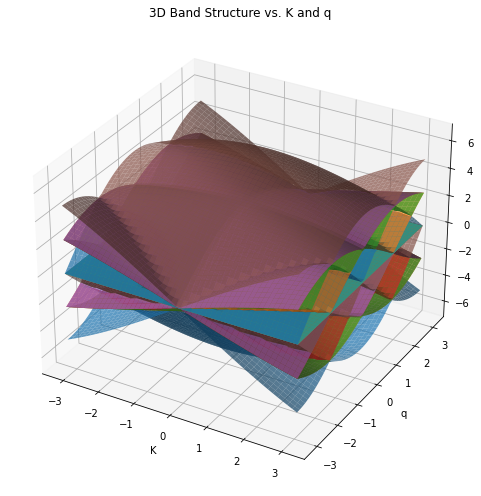

In [117]:
# Parameter grids
Ks = np.linspace(-np.pi, np.pi, 50)
qs = np.linspace(-np.pi, np.pi, 50)
phi = 0

# Determine number of bands
sample = np.sort(continuum_states(H_0, Ks[0], qs[0], phi))
num_bands = len(sample)

# Preallocate energy array
energies = np.zeros((len(qs), len(Ks), num_bands), dtype=float)

# Compute energies
for i, q_val in enumerate(qs):
    for j, K_val in enumerate(Ks):
        energies[i, j, :] = np.sort(continuum_states(H_0, K_val, q_val, phi)).real

# Create meshgrid for plotting
K_mesh, q_mesh = np.meshgrid(Ks, qs)

# Plot 3D band structure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for band_idx in range(num_bands):
    ax.plot_surface(K_mesh, q_mesh, energies[:, :, band_idx],
                    rstride=1, cstride=1, alpha=0.7, linewidth=0)

ax.set_xlabel('K')
ax.set_ylabel('q')
ax.set_zlabel('Energy')
ax.set_title('3D Band Structure vs. K and q')
plt.tight_layout()
plt.show()

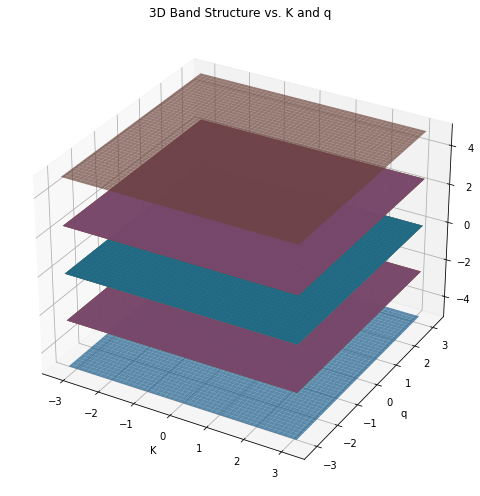

In [120]:
# Parameter grids
Ks = np.linspace(-np.pi, np.pi, 50)
qs = np.linspace(-np.pi, np.pi, 50)
phi = 2*np.pi/3

# Determine number of bands
sample = np.sort(continuum_states(H_0, Ks[0], qs[0], phi))
num_bands = len(sample)

# Preallocate energy array
energies = np.zeros((len(qs), len(Ks), num_bands), dtype=float)

# Compute energies
for i, q_val in enumerate(qs):
    for j, K_val in enumerate(Ks):
        energies[i, j, :] = np.sort(continuum_states(H_0, K_val, q_val, phi)).real

# Create meshgrid for plotting
K_mesh, q_mesh = np.meshgrid(Ks, qs)

# Plot 3D band structure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for band_idx in range(num_bands):
    ax.plot_surface(K_mesh, q_mesh, energies[:, :, band_idx],
                    rstride=1, cstride=1, alpha=0.7, linewidth=0)

ax.set_xlabel('K')
ax.set_ylabel('q')
ax.set_zlabel('Energy')
ax.set_title('3D Band Structure vs. K and q')
plt.tight_layout()
plt.show()

In [121]:
import numpy as np
from scipy.optimize import root_scalar

def bound_states(h0, K, phi, U,
                 n_q=400, n_E=800, E_pad=2.0):
    qs = np.linspace(-np.pi, np.pi, n_q, endpoint=False)
    dql = qs[1] - qs[0]

    eig_p, vec_p, eig_m, vec_m = [], [], [], []
    for q in qs:
        e1, u1 = np.linalg.eigh(h0(phi, K/2 + q))
        e2, u2 = np.linalg.eigh(h0(phi, K/2 - q))
        eig_p.append(e1); vec_p.append(u1)
        eig_m.append(e2); vec_m.append(u2)

    # continuum edges
    all_cont = np.hstack([eig_p[i][:,None] + eig_m[i][None,:]
                          for i in range(n_q)])
    E_min, E_max = all_cont.min(), all_cont.max()

    E_low = E_min - abs(U)*E_pad
    E_high = E_max + abs(U)*E_pad
    E_grid = np.linspace(E_low, E_high, n_E)

    def F(E, l):
        integral = 0.0
        for i in range(n_q):
            e1, u1 = eig_p[i], vec_p[i]
            e2, u2 = eig_m[i], vec_m[i]
            # <-- fixed parentheses here
            amp = (np.abs(u1[:, l])**2)[:, None] \
                * (np.abs(u2[:, l])**2)[None, :]
            denom = E - (e1[:, None] + e2[None, :])
            integral += np.sum(amp / denom) * dql
        return 1.0 - U*(integral/(2*np.pi))

    roots = {l: [] for l in range(3)}
    for l in range(3):
        F_vals = np.array([F(E, l) for E in E_grid])
        for j in range(len(E_grid)-1):
            f0, f1 = F_vals[j], F_vals[j+1]
            if np.isnan(f0) or np.isnan(f1):
                continue
            if f0*f1 < 0:
                sol = root_scalar(lambda E: F(E, l),
                                  bracket=[E_grid[j], E_grid[j+1]],
                                  method='bisect',
                                  xtol=1e-6)
                if sol.converged:
                    roots[l].append(sol.root)
    return roots


# -------------------------------------------------------------
# Example: build the two‐particle band structure vs K
# -------------------------------------------------------------

# parameters
J = 1.0
U = 1.0
phi = np.pi/2

# single‐particle Hamiltonian
H0 = lambda phi, k: np.array([
    [0, np.exp(1j*phi)+np.exp(1j*k),       1+np.exp(1j*k)],
    [np.exp(-1j*phi)+np.exp(-1j*k),       0,            0       ],
    [1+np.exp(-1j*k),                     0,            0       ]
]) * (-J)

# total momentum grid
K_vals = np.linspace(-np.pi, np.pi, 11)

# container for bound bands
bound_bands = {l: np.zeros_like(K_vals) for l in range(3)}

for idx, K in enumerate(K_vals):
    rs = bound_states(H0, K, phi, U)
    for l in range(3):
        # if there is a root in channel l take the one closest to the center of the gap
        bound_bands[l][idx] = rs[l][0] if rs[l] else np.nan

# now you can plot bound_bands[l] vs K alongside the scattering continuum edges


/var/folders/n7/sdrzr_l16mqf79r9kr85jqd80000gn/T/ipykernel_95527/1973255872.py:34: RuntimeWarning: divide by zero encountered in true_divide
  integral += np.sum(amp / denom) * dql
/var/folders/n7/sdrzr_l16mqf79r9kr85jqd80000gn/T/ipykernel_95527/1973255872.py:34: RuntimeWarning: invalid value encountered in true_divide
  integral += np.sum(amp / denom) * dql


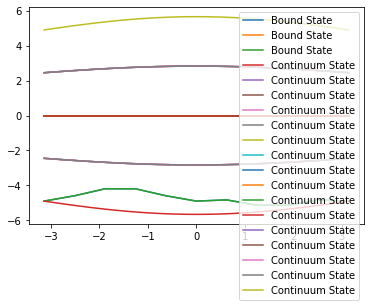

In [151]:
bands = []

for K in Ks:
    bands.append(np.sort(continuum_states(H_0, K, q, phi)))


for idx in range(len(bound_bands)):
    plt.plot(K_vals,bound_bands[idx],label="Bound State")
for band in np.array(bands).T:
    plt.plot(Ks,band,label="Continuum State")

plt.legend()

In [156]:
len(np.array(bands).T)

16

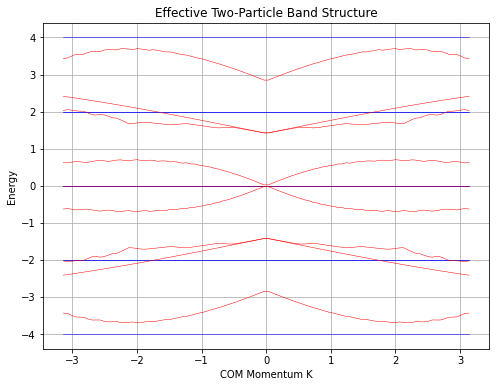

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Single-particle Hamiltonian
def H_0(phi, k):
    return np.array([[0, np.exp(1j*phi) + np.exp(1j*k), 1 + np.exp(1j*k)],
                     [np.exp(-1j*phi) + np.exp(-1j*k), 0, 0],
                     [1 + np.exp(-1j*k), 0, 0]])

# Two-particle interaction (Hubbard onsite U)
def interaction(U):
    V = np.zeros((9,9))
    for i in range(3):
        V[3*i+i,3*i+i] = U
    return V

# Convert indices for the two-particle Hilbert space
def two_particle_ham(phi, K, q, U):
    # Define combined Hamiltonian (9x9)
    H_combined = np.zeros((9,9), dtype=complex)

    # Compute single-particle Hamiltonians
    H_k1 = H_0(phi, K/2 + q)
    H_k2 = H_0(phi, K/2 - q)

    # Fill combined Hamiltonian: H_0(k1) ⊗ I + I ⊗ H_0(k2)
    for a in range(3):
        for b in range(3):
            for c in range(3):
                for d in range(3):
                    H_combined[3*a+b, 3*c+d] = (H_k1[a,c] if b==d else 0) + (H_k2[b,d] if a==c else 0)

    # Add interaction term
    H_combined += interaction(U)

    return H_combined

# Main calculation for fixed COM momentum K
def calculate_band_structure(phi, U, num_q=50):
    K_vals = np.linspace(-np.pi, np.pi, 100)
    energies = np.zeros((len(K_vals),9))

    for idx,K in enumerate(K_vals):
        q_vals = np.linspace(-np.pi, np.pi, num_q)
        all_energies = []
        for q in q_vals:
            H = two_particle_ham(phi, K, q, U)
            eigs = np.linalg.eigvalsh(H)
            all_energies.append(eigs)

        all_energies = np.array(all_energies)
        
        # Here, the bands for two particles are continuous in q.
        # Bound states appear separated from continuum bands.
        # For simplicity, plot min and max continuum energies plus potential bound states.

        # Continuum bands
        min_continuum = np.min(all_energies, axis=0)
        max_continuum = np.max(all_energies, axis=0)

        energies[idx,:] = (min_continuum + max_continuum) / 2

    return K_vals, energies

# Example usage:
phi = np.pi
U = 0  # strong onsite interaction
K_vals, energies = calculate_band_structure(phi, U)

# Plotting
plt.figure(figsize=(8,6))
for i in range(energies.shape[1]):
    plt.plot(K_vals, energies[:,i], color='blue', lw=0.5)

uK_vals, uenergies = calculate_band_structure(0, U)

# Plotting
for i in range(energies.shape[1]):
    plt.plot(uK_vals, uenergies[:,i], color='red', lw=0.5)

plt.xlabel('COM Momentum K')
plt.ylabel('Energy')
plt.title('Effective Two-Particle Band Structure')
plt.grid(True)
plt.show()


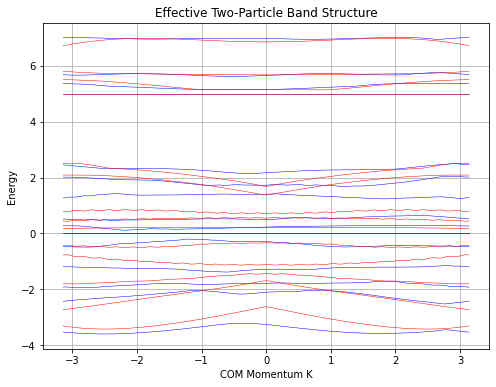

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Single-particle Hamiltonian
def H_0(phi, k):
    return add_conj(np.array([[0, np.exp(1j*phi/2) +np.exp(-1j*(k+phi/2)), 1 + np.exp(-1j*k), np.exp(-1j*phi/2) +np.exp(-1j*(k-phi/2))],[0,0,0,0],[0,0,0,0],[0,0,0,0]] ))

# Two-particle interaction (Hubbard onsite U)
def interaction(U):
    V = np.zeros((16,16))
    for i in range(4):
        V[4*i+i,4*i+i] = U
    return V

# Convert indices for the two-particle Hilbert space
def two_particle_ham(phi, K, q, U):
    # Define combined Hamiltonian (9x9)
    H_combined = np.zeros((16,16), dtype=complex)

    # Compute single-particle Hamiltonians
    H_k1 = H_0(phi, K/2 + q)
    H_k2 = H_0(phi, K/2 - q)

    # Fill combined Hamiltonian: H_0(k1) ⊗ I + I ⊗ H_0(k2)
    for a in range(4):
        for b in range(4):
            for c in range(4):
                for d in range(4):
                    H_combined[3*a+b, 3*c+d] = (H_k1[a,c] if b==d else 0) + (H_k2[b,d] if a==c else 0)

    # Add interaction term
    H_combined += interaction(U)

    return H_combined

# Main calculation for fixed COM momentum K
def calculate_band_structure(phi, U, num_q=50):
    K_vals = np.linspace(-np.pi, np.pi, 100)
    energies = np.zeros((len(K_vals),16))

    for idx,K in enumerate(K_vals):
        q_vals = np.linspace(-np.pi, np.pi, num_q)
        all_energies = []
        for q in q_vals:
            H = two_particle_ham(phi, K, q, U)
            eigs = np.linalg.eigvalsh(H)
            all_energies.append(eigs)

        all_energies = np.array(all_energies)
        
        # Here, the bands for two particles are continuous in q.
        # Bound states appear separated from continuum bands.
        # For simplicity, plot min and max continuum energies plus potential bound states.

        # Continuum bands
        min_continuum = np.min(all_energies, axis=0)
        max_continuum = np.max(all_energies, axis=0)

        energies[idx,:] = (min_continuum + max_continuum) / 2

    return K_vals, energies

# Example usage:
phi = np.pi/3
U = 5 # strong onsite interaction
K_vals, energies = calculate_band_structure(phi, U)

# Plotting
plt.figure(figsize=(8,6))
for i in range(energies.shape[1]):
    plt.plot(K_vals, energies[:,i], color='blue', lw=0.5)

uK_vals, uenergies = calculate_band_structure(0, U)

# Plotting
for i in range(energies.shape[1]):
    plt.plot(uK_vals, uenergies[:,i], color='red', lw=0.5)

plt.xlabel('COM Momentum K')
plt.ylabel('Energy')
plt.title('Effective Two-Particle Band Structure')
plt.grid(True)
plt.show()
